In [2]:
from __future__ import print_function, division
from skimage.io import imread, imsave
from tifffile import TiffFile
from datetime import datetime

import os
import numpy as np
import matplotlib.pyplot as plt
import pylab
from windrose import WindroseAxes

from scipy.ndimage import label, median_filter, binary_opening
from skimage.morphology import square, cube

###----------------------------------------------------------------------

def load_orientation_files(fpath, str_filter, file_type):
    
    files = os.listdir(fpath)
    filt_files = []
    filt_names = []
    
    for i in files:
        if str_filter in i:
            if file_type == '.tif':
                filt_files.append(imread(os.path.join(fpath,i)))
            elif file_type == '.npy':
                filt_files.append(np.load(os.path.join(fpath,i)))
            filt_names.append(i)
        else:
            continue
    
    return filt_files, filt_names

###----------------------------------------------------------------------

def load_retardance_files(fpath, str_filter, ceiling_filter = 'Retardance Ceiling (nm)'):
    
    files = os.listdir(fpath)
    
    filt_files = []
    filt_ceilings = []
    filt_names = []
    
    for i in files:
        
        if str_filter in i:
            with TiffFile(os.path.join(fpath, i)) as tif:
                arr = tif.asarray()
                imagej_metadata = tif.imagej_metadata 
            #test_metadata = list(imagej_metadata.values())[-1].split(',')
            test_metadata = str(imagej_metadata).split(',')
            
            counter = 0
            for j in test_metadata:
                if ceiling_filter in j:
                    break
                counter += 1
            ceiling = int(test_metadata[counter].split(':')[-1])
            
            filt_files.append(arr)
            filt_ceilings.append(ceiling)
            filt_names.append(i)
        else:
            continue
    
    return filt_files, filt_ceilings, filt_names
    
###----------------------------------------------------------------------

def prepro_orientation(files, process_type = 'float'):
    
    prepro_files = [0] * len(files)
    counter = 0
    for i in files:
        if process_type == 'float':
            prepro_files[counter] = np.around(i/100, decimals = 3).astype(float)
            counter += 1
        elif process_type == 'int':
            prepro_files[counter] = (i/100).astype(i.dtype)
            counter += 1
        else:
            print('unknown process type')
        
    return prepro_files

###----------------------------------------------------------------------

def prepro_retardance(files, ceilings, process_type = 'float', floor = 0):
    
    prepro_files = [0] * len(files)
    for i in range(len(files)):
        i_arr = files[i]
        i_ceil = ceilings[i]
        if process_type == 'float':
            prepro_files[i] = np.around(i_arr/i_ceil, decimals = 3).astype(float)
        elif process_type == 'int':
            prepro_files[i] = (i_arr/i_ceil).astype(i.dtype)
    
    return prepro_files

###----------------------------------------------------------------------

def percentile_pairs(arr, step_size):
    
    idx_steps = np.arange(0, 101, step_size)
    arr_steps = np.percentile(arr, idx_steps).astype(float)
    val_pairs = np.asarray([(arr_steps[i], arr_steps[i+1]) for i in range(arr_steps.shape[0]-1)])
    
    return idx_steps, arr_steps, val_pairs

###----------------------------------------------------------------------

def filter_arr_vals(arr, val_pairs):
    
    expanded_arr = np.empty(np.concatenate(((val_pairs.shape[0],), arr.shape)))
    
    for i in range(val_pairs.shape[0]):
        p = val_pairs[i,:]
        i_arr = np.copy(arr)
        i_arr[arr <= p[0]] = 0
        i_arr[arr > p[1]] = 0
        expanded_arr[i, ...] = i_arr
    
    return expanded_arr

###----------------------------------------------------------------------

def check_pixel_balance(expanded_arr, n_checks):
    
    '''something is wrong with this function. n_checks = expanded_arr.shape[0]'''
    
    px_cts = np.empty(n_checks, dtype = int)
    
    for i in range(n_checks):
        px_cts[i] = np.sum(expanded_arr[i,...].astype(bool).astype(np.uint8))
    
    return px_cts

###----------------------------------------------------------------------

def label_expansion(expanded_arr, noise_se_size = 3):
    
    '''runs with minimial small noise removal.'''
    
    dims = len(expanded_arr.shape)-1
    n_layers = expanded_arr.shape[0]
    
    labeled_arr = np.empty_like(expanded_arr)
    obj_ct = np.empty(n_layers, dtype=int)
    
    if dims == 3:
        noise_se = np.ones((noise_se_size, noise_se_size, noise_se_size), dtype=np.uint8)
        label_se = np.ones((3,3,3), dtype=np.uint8)
    elif dims == 2:
        noise_se = np.ones((noise_se_size, noise_se_size), dtype=np.uint8)
        label_se = np.ones((3,3), dtype=np.uint8)
    else:
        print('problem!')
    
    for i in range(n_layers):
        i_arr = expanded_arr[i,...]
        i_lab, i_ct = label(binary_opening(i_arr, structure=noise_se), structure=label_se)
        labeled_arr[i,...] = i_lab
        obj_ct[i] = i_ct
    
    return labeled_arr, obj_ct

###----------------------------------------------------------------------

def det_obj_sizes(labeled_arr, obj_ct, n_layers, bg_val = 0):
    
    '''n_layers = labeled_arr.shape[0]'''
    
    sizes = [0] * n_layers
    for i in range(n_layers):
        i_arr = labeled_arr[i,...]
        
        i_sizes = np.empty((obj_ct[i]+1), dtype = int)
        for j in range(obj_ct[i]+1):
            if j > bg_val:
                i_sizes[j] = np.where(i_arr.flatten() == j)[0].shape[0]
            else:
                i_sizes[j] = 0
        
        sizes[i] = np.vstack((np.arange(obj_ct[i]+1), i_sizes)).T
    
    return sizes

###----------------------------------------------------------------------

def mask_adj_obj(arr, labeled_arr):
    
    mask = np.sum(labeled_arr, axis = 0).astype(bool)
    indexed = np.copy(arr)
    indexed[mask == False] = 0
    print(indexed.shape)
    
    dims = len(arr.shape)
    if dims == 3:
        se = np.ones((3,3,3))
    elif dims == 2:
        se = np.ones((3,3))
    else:
        print('problem!')
    
    umbrella_label, n = label(indexed, structure = se)
    
    return mask, indexed, umbrella_label, n

###----------------------------------------------------------------------

def orientation_angles(indexed_arr):
    
    x = indexed_arr.flatten()
    x = x[x > 0]
    
    return x

###----------------------------------------------------------------------

def rotate_angles(angles, val):
    
    rotated = np.empty_like(angles)
    
    for i in range(angles.shape[0]):
        i_a = angles[i]
        if i_a < val:
            rotated[i] = i_a - val + 180
        else:
            rotated[i] = i_a - val
    
    return rotated


new image:


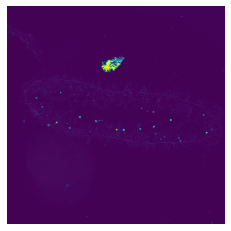

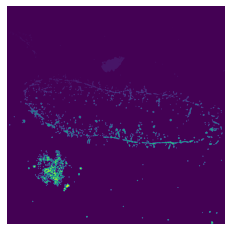


new image:


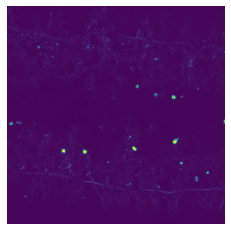

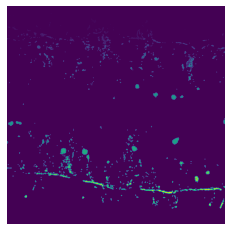


new image:


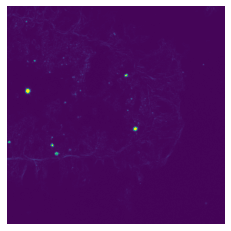

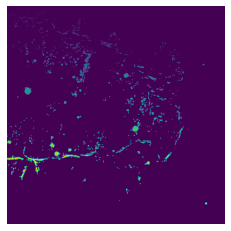


new image:


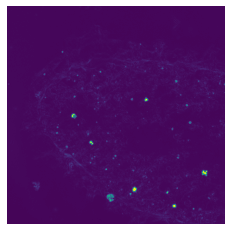

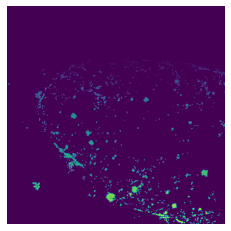


new image:


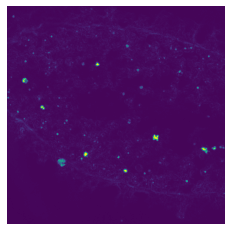

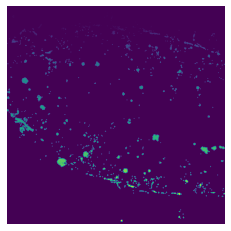


new image:


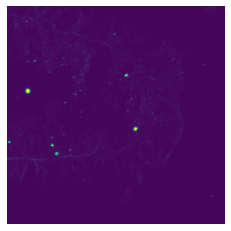

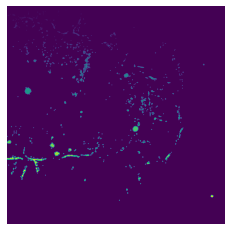


new image:


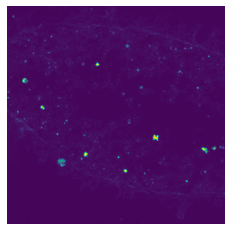

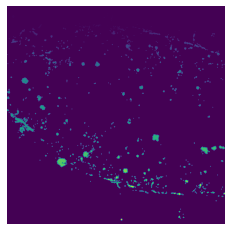


new image:


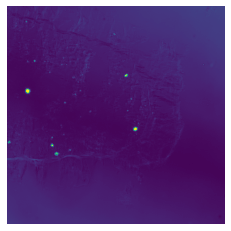

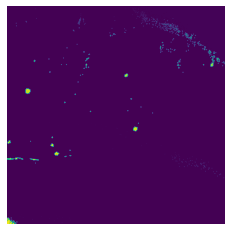


new image:


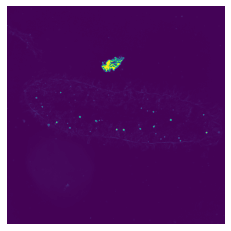

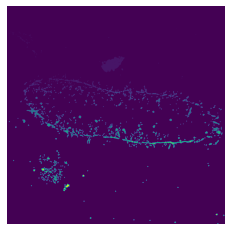


new image:


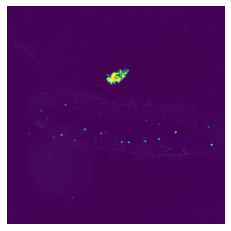

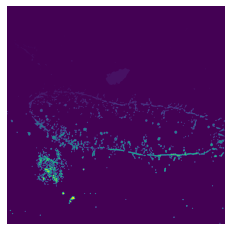


new image:


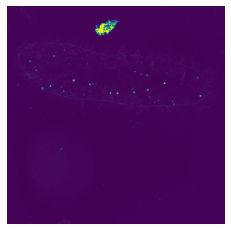

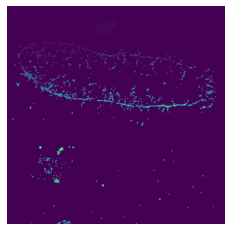


new image:


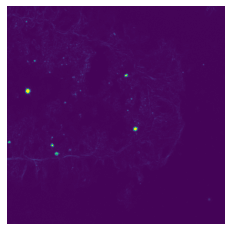

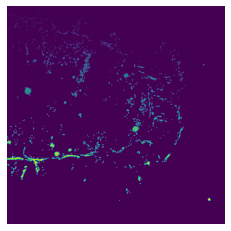

<ipython-input-20-c04f90a207cd>:53: UserWarning: /Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c/2023-02-08_analysis_stepsize_10_Retardance/SM_2022_1207_1613_1_Slide1c_20x_Retardance_labeled.tif is a low contrast image
  imsave(os.path.join(save_path, names[i][:-str_trim] + '_labeled.tif'), labeled_arrs[i].astype(np.uint16))
<ipython-input-20-c04f90a207cd>:54: UserWarning: /Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c/2023-02-08_analysis_stepsize_10_Retardance/SM_2022_1207_1613_1_Slide1c_20x_Retardance_filtered.tif is a low contrast image
  imsave(os.path.join(save_path, names[i][:-str_trim] + '_filtered.tif'), filt_arrs[i].astype(np.uint16))
<ipython-input-20-c04f90a207cd>:53: UserWarning: /Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c/2023-02-08_analysis_stepsize_10_Retardance/SM_2022_1207_1644_1_Slide1c_60x_e_Sec2_300ms_Retardance_labeled.tif is a low contrast image
  imsave(os.path.join(save_path, names[i][:-str_trim] + '_labeled.tif'), labeled_a

In [20]:
## basic retardance analysis pipeline

fpath = r'/Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c'
str_filter = 'Retardance'
step_size = 10

arrs, ceilings, names = load_retardance_files(fpath, str_filter)
norm_arrs = prepro_retardance(arrs, ceilings)
n_arrs = len(norm_arrs)

p_pairs = [0] * n_arrs
filt_arrs = [0] * n_arrs
labeled_arrs = [0] * n_arrs
obj_sizes = [0] * n_arrs

counter = 0
for i in norm_arrs:
    print('new image:')
    plt.imshow(i)
    plt.axis('off')
    plt.show()
    
    idx_steps, arr_steps, val_pairs = percentile_pairs(i, step_size)
    filt = filter_arr_vals(i, val_pairs)
    labeled, ct = label_expansion(filt, noise_se_size=5)
    #sizes = det_obj_sizes(labeled, ct, labeled.shape[0])
    plt.imshow(labeled.sum(axis = 0))
    plt.axis('off')
    plt.show()
    
    p_pairs[counter] = val_pairs
    filt_arrs[counter] = filt
    labeled_arrs[counter] = labeled
    #obj_sizes[counter] = sizes
    
    counter += 1
    print()

str_trim = len('.tif')
date = datetime.now().isoformat(sep = '_', timespec = 'seconds').split('_')[0]
save_path = os.path.join(fpath, date + '_analysis_stepsize_' + str(step_size) + '_' + str_filter)
os.mkdir(save_path)

#save_names = ('ceiling', 'norm','bins')
save_names = ('ceiling','norm','bins','labeled', 'sizes')
#save_files = (ceilings, norm_arrs, p_pairs)
save_files = (ceilings, norm_arrs, p_pairs, labeled_arrs, obj_sizes)
for i in range(len(names)):
    for j in range(len(save_names)):
        np.save(os.path.join(save_path, names[i][:-str_trim] + '_' + save_names[j]), save_files[j][i])
        
for i in range(len(names)):
    imsave(os.path.join(save_path, names[i][:-str_trim] + '_labeled.tif'), labeled_arrs[i].astype(np.uint16))
    imsave(os.path.join(save_path, names[i][:-str_trim] + '_filtered.tif'), filt_arrs[i].astype(np.uint16))

new image:


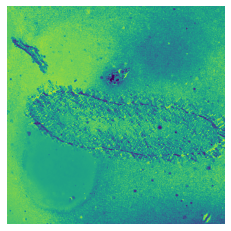

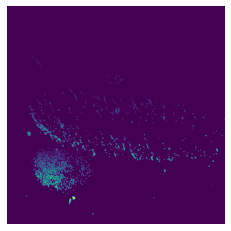


new image:


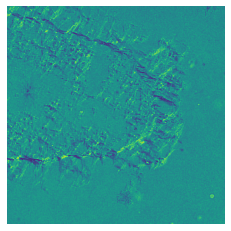

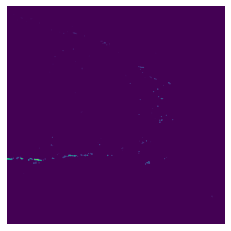


new image:


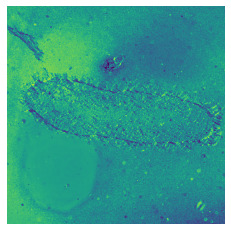

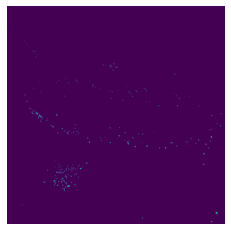


new image:


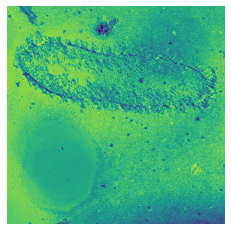

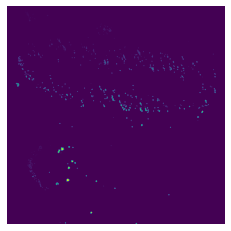


new image:


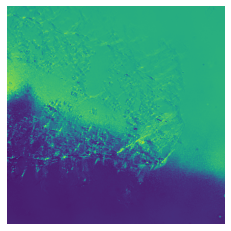

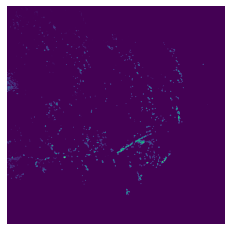


new image:


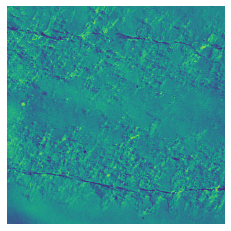

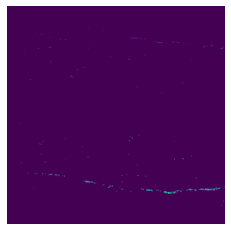


new image:


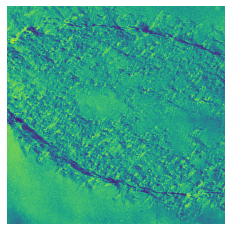

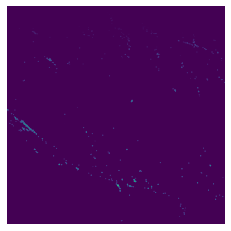


new image:


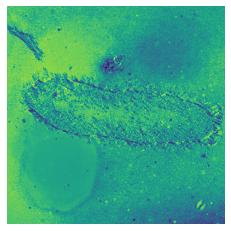

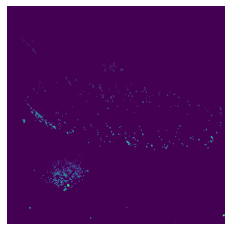


new image:


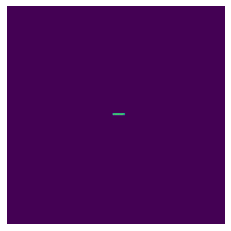

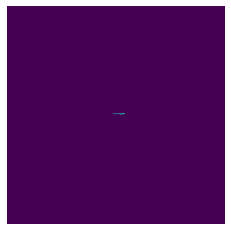


new image:


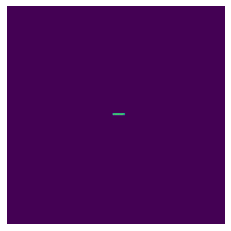

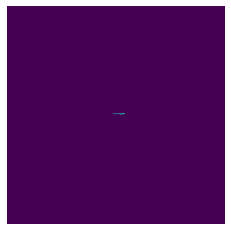


new image:


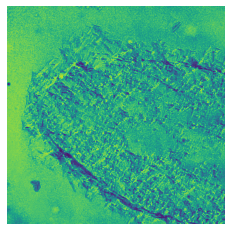

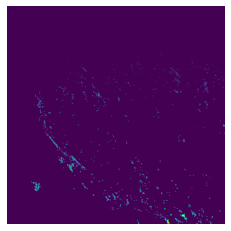


new image:


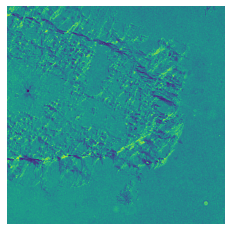

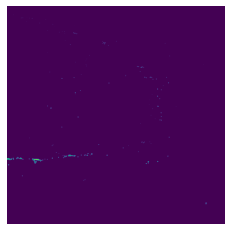

<ipython-input-21-f6fb19d3a094>:54: UserWarning: /Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c/2023-02-08_analysis_stepsize_10_Orientation/SM_2022_1207_1621_1_Slide1c_20x_3rd_Orientation_labeled.tif is a low contrast image
  imsave(os.path.join(save_path, names[i][:-str_trim] + '_labeled.tif'), labeled_arrs[i].astype(np.uint16))
<ipython-input-21-f6fb19d3a094>:55: UserWarning: /Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c/2023-02-08_analysis_stepsize_10_Orientation/SM_2022_1207_1621_1_Slide1c_20x_3rd_Orientation_filtered.tif is a low contrast image
  imsave(os.path.join(save_path, names[i][:-str_trim] + '_filtered.tif'), filt_arrs[i].astype(np.uint16))
<ipython-input-21-f6fb19d3a094>:54: UserWarning: /Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c/2023-02-08_analysis_stepsize_10_Orientation/SM_2022_1207_1633_1_Slide1c_60x_b_Sec1_Foot_NewBG_Orientation_labeled.tif is a low contrast image
  imsave(os.path.join(save_path, names[i][:-str_trim] + '_label

In [21]:
## basic orientation analysis pipeline

fpath = r'/Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c'
str_filter = 'Orientation'
file_type = '.tif'
step_size = 10

arrs, names = load_orientation_files(fpath, str_filter, file_type)
norm_arrs = prepro_orientation(arrs)
n_arrs = len(norm_arrs)

p_pairs = [0] * n_arrs
filt_arrs = [0] * n_arrs
labeled_arrs = [0] * n_arrs
obj_sizes = [0] * n_arrs

counter = 0
for i in norm_arrs:
    print('new image:')
    plt.imshow(i)
    plt.axis('off')
    plt.show()
    
    idx_steps, arr_steps, val_pairs = percentile_pairs(i, step_size)
    filt = filter_arr_vals(i, val_pairs)
    labeled, ct = label_expansion(filt, noise_se_size=5)
    #sizes = det_obj_sizes(labeled, ct, labeled.shape[0])
    plt.imshow(labeled.sum(axis = 0))
    plt.axis('off')
    plt.show()
    
    p_pairs[counter] = val_pairs
    filt_arrs[counter] = filt
    labeled_arrs[counter] = labeled
    #obj_sizes[counter] = sizes
    
    counter += 1
    print()
    
str_trim = len('.tif')
date = datetime.now().isoformat(sep = '_', timespec = 'seconds').split('_')[0]
save_path = os.path.join(fpath, date + '_analysis_stepsize_' + str(step_size) + '_' + str_filter)
os.mkdir(save_path)

save_names = ('norm','bins','labeled', 'sizes')
#save_names = ('norm','bins')
save_files = (norm_arrs, p_pairs, labeled_arrs, obj_sizes)
#save_files = (norm_arrs, p_pairs)
for i in range(len(names)):
    for j in range(len(save_names)):
        np.save(os.path.join(save_path, names[i][:-str_trim] + '_' + save_names[j]), save_files[j][i])
        
for i in range(len(names)):
    imsave(os.path.join(save_path, names[i][:-str_trim] + '_labeled.tif'), labeled_arrs[i].astype(np.uint16))
    imsave(os.path.join(save_path, names[i][:-str_trim] + '_filtered.tif'), filt_arrs[i].astype(np.uint16))

# ---------------------------------------------------------

In [3]:
from pylab import get_cmap
from matplotlib.colors import ListedColormap

# simple generator with black rgba background
cb_cmap = get_cmap('hsv', 10) # lut == n_percentile pairs ???
colors = cb_cmap(np.linspace(0,1,11))

black = np.reshape(np.asarray([0,0,0,1]), (1,4))
white = np.reshape(np.asarray([255, 255, 255,1]), (1,4))

colors_black = np.concatenate((black, colors), axis = 0)
#lut_path = r'/Users/ryan/Desktop'
#np.savetxt(os.path.join(lut_path, 'hsv colormap with black background.txt'), colors_black, delimiter=',')

(2048, 2048)


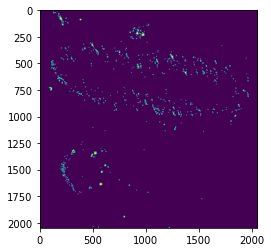

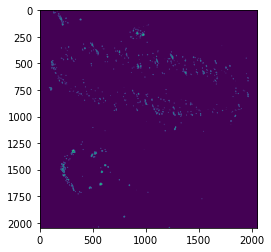

518


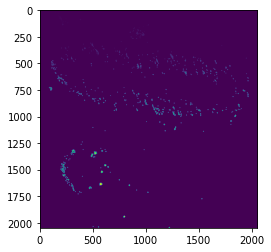

(2048, 2048)


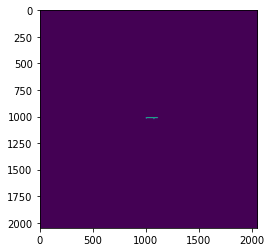

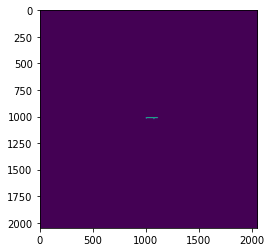

4


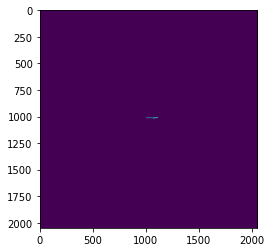

(2048, 2048)


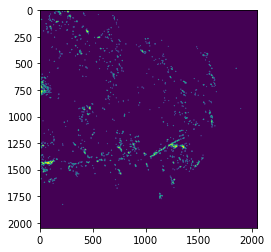

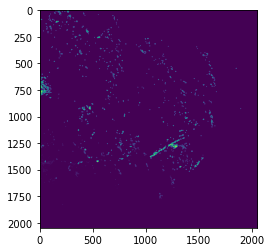

855


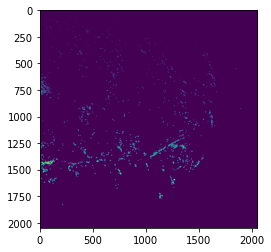

(2048, 2048)


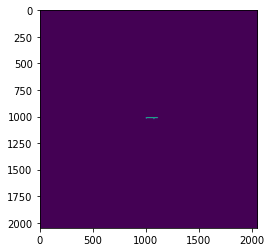

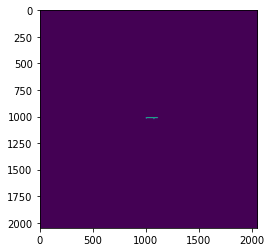

4


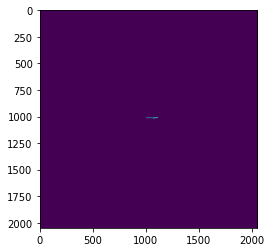

(2048, 2048)


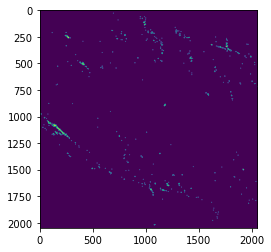

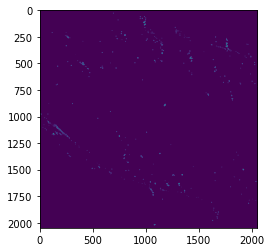

359


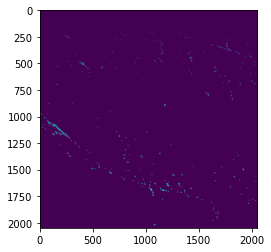

(2048, 2048)


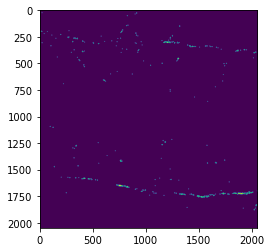

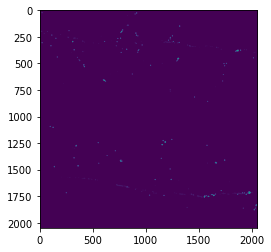

236


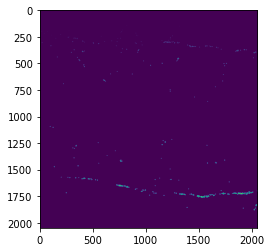

(2048, 2048)


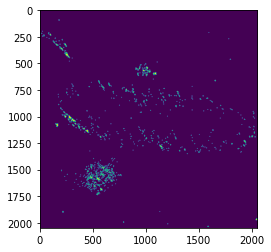

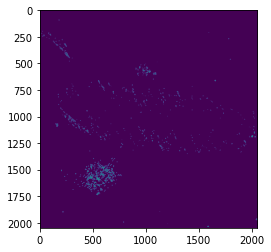

644


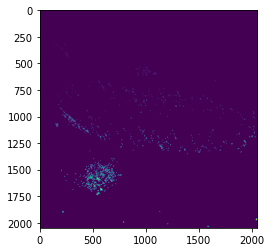

(2048, 2048)


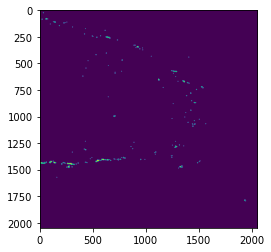

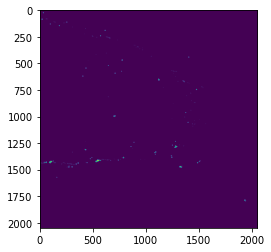

151


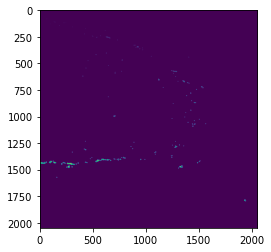

(2048, 2048)


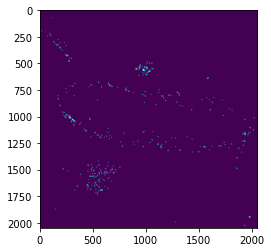

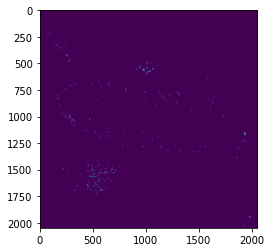

303


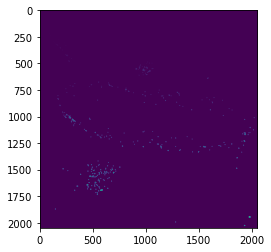

(2048, 2048)


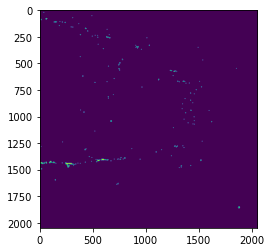

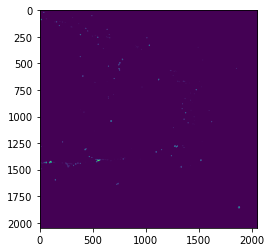

156


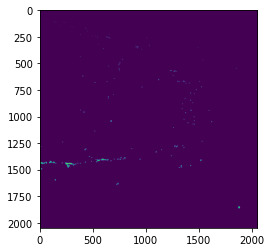

(2048, 2048)


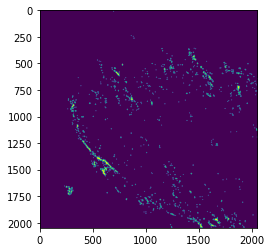

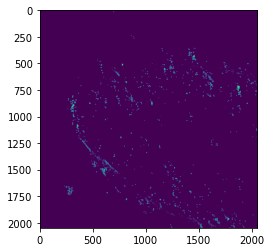

796


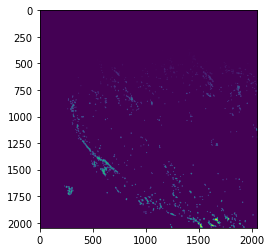

(2048, 2048)


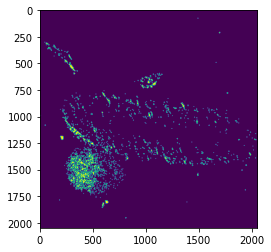

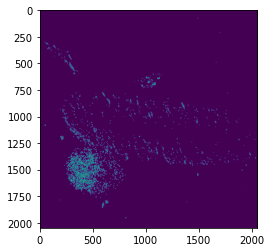

1146


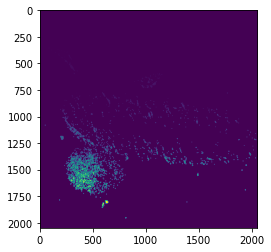

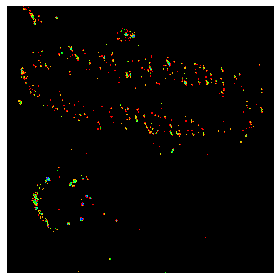

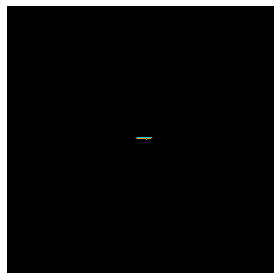

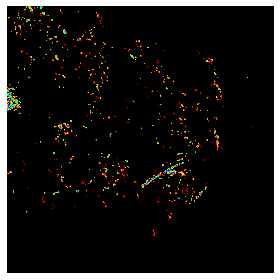

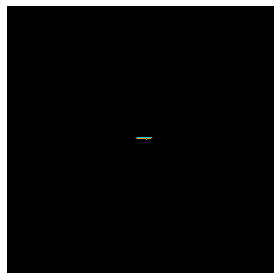

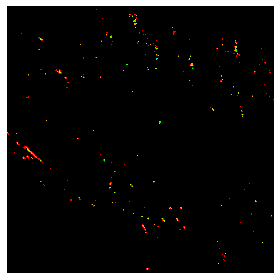

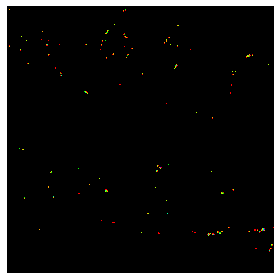

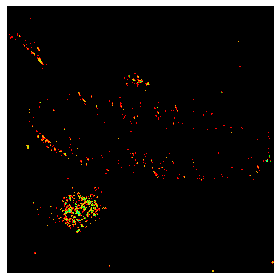

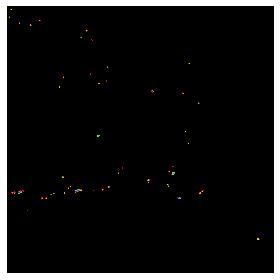

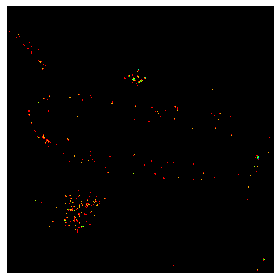

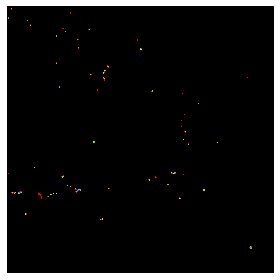

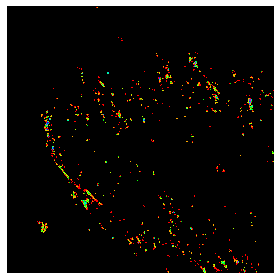

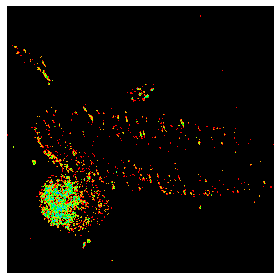

<ipython-input-22-fe00c40fde28>:71: UserWarning: /Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c/2023-02-08_analysis_stepsize_10_Orientation/SM_2022_1207_1623_1_Slide1c_20x_4th_AvoidWeirdSpot_Orie_idx_original.tif is a low contrast image
  imsave(os.path.join(fpath, names[i][:-str_trim] + '_idx_original.tif'), idx_original[i].astype(np.uint16))
<ipython-input-22-fe00c40fde28>:72: UserWarning: /Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c/2023-02-08_analysis_stepsize_10_Orientation/SM_2022_1207_1623_1_Slide1c_20x_4th_AvoidWeirdSpot_Orie_umbrella.tif is a low contrast image
  imsave(os.path.join(fpath, names[i][:-str_trim] + '_umbrella.tif'), umbrellas[i].astype(np.uint16))
<ipython-input-22-fe00c40fde28>:71: UserWarning: /Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c/2023-02-08_analysis_stepsize_10_Orientation/SM_2022_1207_1635_1_Slide1c_60x_c_Sec1_Foot_400ms_Failed_Orie_idx_original.tif is a low contrast image
  imsave(os.path.join(fpath, names[i][:-

In [22]:
## use labeled retardance/orientation images to create binary masks for indexing

fpath = r'/Users/ryan/Desktop/polo/PLM_data/2022_12_07_Anais/Slide1c/2023-02-08_analysis_stepsize_10_Orientation'
arr_filter = 'norm'
lab_filter = 'labeled'
file_type = '.npy'

str_trim = len(arr_filter) + len(file_type)

files = os.listdir(fpath)

arrs = []
labs = []
names = []
for i in files:
    if arr_filter in i:
        arrs.append(np.load(os.path.join(fpath, i)))
        labs.append(np.load(os.path.join(fpath, i[:-str_trim] + lab_filter + file_type)))
        names.append(i[:-str_trim])
    else:
        continue

bg_val = 0

binary_masks = [0] * len(arrs)
idx_original = [0] * len(arrs)
umbrellas = [0] * len(arrs)
umb_sizes = [0] * len(arrs)

for i in range(len(arrs)):
    mask, indexed, umbrella_label, n = mask_adj_obj(arrs[i], labs[i])
    ids = np.arange((n+1), dtype = np.uint16)
    sizes = np.empty((n), dtype = np.uint16)
    for j in range(n):
        if j > bg_val:
            sizes[j] = np.where(umbrella_label.flatten() == j)[0].shape[0]
        else:
            sizes[j] = 0
            
    binary_masks[i] = mask
    idx_original[i] = indexed
    umbrellas[i] = umbrella_label
    umb_sizes[i] = sizes
    
    plt.imshow(mask)
    plt.show()
    plt.imshow(indexed)
    plt.show()
    print(n)
    plt.imshow(umbrella_label)
    plt.show()
    
for i in range(len(idx_original)):
    i_idx = idx_original[i]
    i_lab = umbrellas[i]
    
    plt.imshow(i_idx, cmap=ListedColormap(colors_black)) #orientation
    #plt.imshow(i_idx, cmap = 'Greys') #retardance
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(fpath, names[i] + 'mask_orig_idx.png'), dpi = 600)
    plt.show()
    
save_names = ('binary_mask','idx_original','umbrella', 'umbrella_sizes')
save_files = (binary_masks, idx_original, umbrellas, umb_sizes)
for i in range(len(names)):
    for j in range(len(save_names)):
        np.save(os.path.join(fpath, names[i][:-str_trim] + '_' + save_names[j]), save_files[j][i])
        
for i in range(len(names)):
    imsave(os.path.join(fpath, names[i][:-str_trim] + '_idx_original.tif'), idx_original[i].astype(np.uint16))
    imsave(os.path.join(fpath, names[i][:-str_trim] + '_umbrella.tif'), umbrellas[i].astype(np.uint16))

# ---------------------------------------------------------

In [ ]:
#def cyclic_colormap_sampling(n):
#    
#    '''returns...'''
#    
#    return sampled_rgba_values
#
#def export_lut_rgba(cmap_values):
#    
#    '''saves matplotlib format rgba value LUT as a text file and/or as a numpy file'''
#    
#    return lut_file
#
#def export_lut_rgb(cmap_values):
#    
#    '''converts and saves a matplotlib format rgba value LUT as an RGB text file that can be imported to FIJI'''
#    
#    return lut_file
#
#def index_roi_angles(...):
#    
#    return roi_info

In [ ]:
#fpath = r'/Users/ryan/Desktop/J. Brugués/PLM_data/20221220_1100 Allyson_polscope/retardance'
#files = os.listdir(fpath)
#for i in files:
#
#    with TiffFile(os.path.join(fpath, i)) as tif:
#        arr = tif.asarray()
#        imagej_metadata = tif.imagej_metadata 
#        print(imagej_metadata)
#        
#counter = -1
#for i in str(imagej_metadata).split(','):
#    counter += 1
#    if 'Ceiling' in i:
#        print(i, counter)
#        break